тут мы считаем тепловую карту меток, а также окьюпанси мэп, причем последнюю мы поворачиваем на 90 градусов
а метки мы до этого зеркалили в коде миррор и с охраняли в файлах типа kkmark_3.png. все это сделано для того, чтобы тепловые карты соответствовали друг другу

In [2]:
import traja
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import signal
from scipy import misc
from scipy import stats
%matplotlib inline
#plt.style.use('seaborn-whitegrid')
#im = cv2.imread(r"C:\\Users\\Lenovo\\1navigation\\angel.png")

In [12]:
#из считанной картинки с метками делаем таблицу с координатами красных пикселей
def RedDFFromIm(im):
    coords = []
    xmax = im.shape[0]
    ymax = im.shape[1]
    for i in range(len(im)):
        for j in range(len(im[i])):
            if (int(im[i][j][2]) - int(im[i][j][0]) > 15) and (int(im[i][j][2]) - int(im[i][j][0]) > 15):
                coords.append([i,j,im[i][j][2],im[i][j][1],im[i][j][0]])
    df = pd.DataFrame(coords, columns =['x', 'y', 'red', 'green', 'blue'])
    fig, ax = plt.subplots()
    ax.set_xlim(xmax)
    ax.set_ylim(ymax)
    ax.set_aspect('equal', adjustable='box')
    plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)
    #sns.scatterplot(data=df, ax=ax, x="x", y="y",marker='.')
    plt.show()
    marks = {'df':df, 'xmax':xmax, 'ymax':ymax}
    return(marks)

#делаем тепловую карту по меткам (input: df+xmax+ymax)
def make_occup_map(marks, n):
    df = marks['df']
    xmax = marks['xmax']
    ymax = marks['ymax']
    binx = np.linspace(0, xmax, n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    #print(x_cut)

    biny = np.linspace(0, ymax, n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    #print(y_cut)

    dfn = df.groupby([x_cut, y_cut]).count()
    
    
    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))
    dfm = dfm.drop(columns=['x','y', 'green', 'blue'])
    dd = dfm.unstack()
    dd = dd.replace(0, 1.e-1)
    arrd = dd.to_numpy()
    #arrl = np.log(arrd)
    arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    kk = (arrsrsr - np.amin(arrsrsr)) / (np.amax(arrsrsr) - np.amin(arrsrsr))
    kk = pd.DataFrame(kk)
    plt.figure()
    sns.heatmap(kk, square=True, xticklabels=False, yticklabels=False)
    return(kk)

In [3]:
# Python 3 program for left rotation of matrix by 90
# degree without using extra space
 
R = 20
C = 20
 
# After transpose we swap elements of column
# one by one for finding left rotation of matrix
# by 90 degree
 
def reverseColumns(arr):
    for i in range(C):
        j = 0
        k = C-1
        while j < k:
            t = arr[j][i]
            arr[j][i] = arr[k][i]
            arr[k][i] = t
            j += 1
            k -= 1

#Function for do transpose of matrix
 
def transpose(arr):
    for i in range(R):
        for j in range(i, C):
            t = arr[i][j]
            arr[i][j] = arr[j][i]
            arr[j][i] = t
#Function for print matrix 
 
def printMatrix(arr):
    for i in range(R):
        for j in range(C):
            print(str(arr[i][j]), end=" ")
        print()

# Function to anticlockwise rotate matrix
# by 90 degree
 
def rotate90(arr):
    transpose(arr)
    reverseColumns(arr)

In [15]:
def openFile(ff):
    df = pd.read_csv(ff, sep=" ",header = None, names=['numb', 'time', 'x', 'y'])
    df = df.drop('numb', axis=1)
    #df = df.drop(df[df.time > 1755].index)
    df.traja.plot()
    #plt.savefig('C:\\Users\\Lenovo\\1navigation\\orig\\' + ff[:-4] + '.png')
    return(df)

#
def occupMapNorm(df,n):
    xmin = df["x"].min() - 0.1
    xmax = df["x"].max() + 0.1
    binx = np.linspace(xmin, xmax, n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    #делаем df где будет понятно сколько было точек в каждом бине 
    #соответсвуеющему данному интервалу х и данному интервалу у
    ymin = df["y"].min() - 0.1
    ymax = df["y"].max() + 0.1
    biny = np.linspace(ymin, ymax, n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut]).count()
    
    print(x_cut.isnull().values.any(), y_cut.isnull().values.any())
    
    dfn = dfn.drop(columns=['x','y'])
    dfn = dfn.rename(columns={'time': 'Count'})
    
    #сделаем df с норм числами в индексах, а не с интервалами
    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))
    
    dd = dfm.unstack()
    dd = dd.replace(0, 1.e-1)
    arrd = dd.to_numpy()
    arrl = np.log(arrd)
    arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    rotate90(arrl)
    kk = (arrl - np.amin(arrl)) / (np.amax(arrl) - np.amin(arrl))
    kk = pd.DataFrame(kk)
    plt.figure()
    sns.heatmap(kk, square=True)
    #sns.heatmap(arrl, square=True, xticklabels=False, yticklabels=False)
    return(kk)

### Получим карты меток

In [7]:
im3 = cv2.imread("C:\\Users\\Lenovo\\1navigation\\marks\\kkmark_3.png")
im5 = cv2.imread("C:\\Users\\Lenovo\\1navigation\\marks\\kkmark_5.png")
im6 = cv2.imread("C:\\Users\\Lenovo\\1navigation\\marks\\kkmark_6.png")
im7 = cv2.imread("C:\\Users\\Lenovo\\1navigation\\marks\\kkmark_7.png")
im91 = cv2.imread("C:\\Users\\Lenovo\\1navigation\\marks\\kkmark_9.1.png")
im92 = cv2.imread("C:\\Users\\Lenovo\\1navigation\\marks\\kkmark_9.2.png")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35336\2046163448.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)


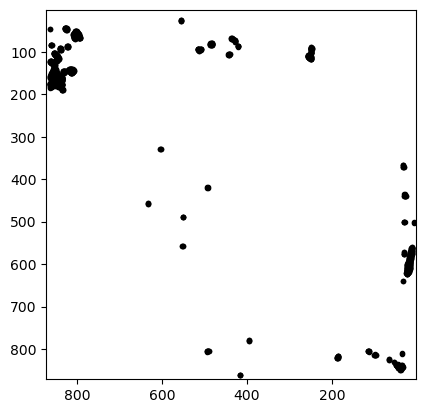

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35336\2046163448.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)


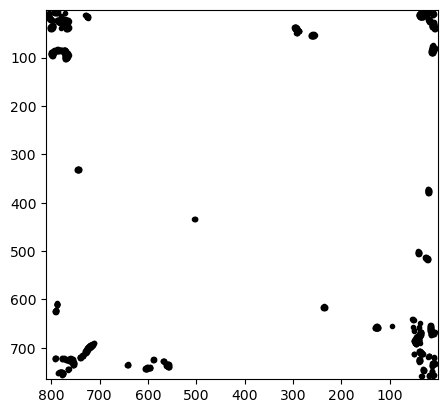

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35336\2046163448.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)


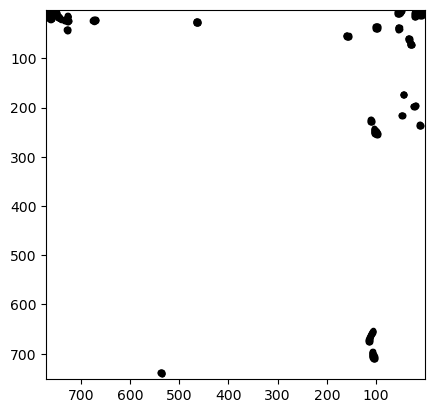

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35336\2046163448.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)


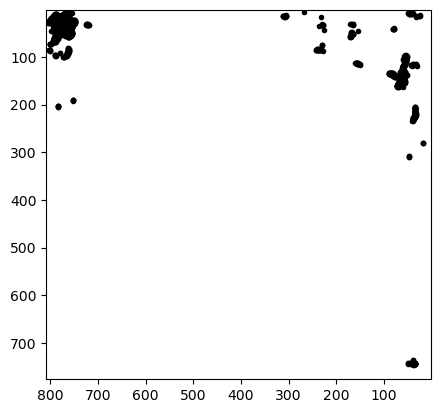

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35336\2046163448.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)


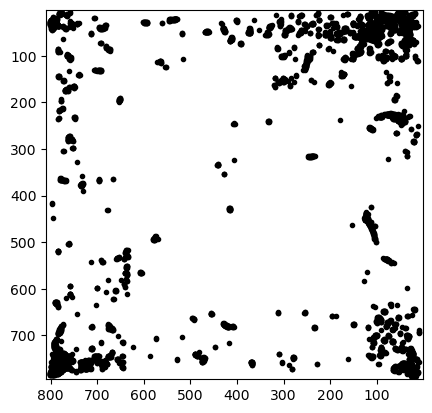

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35336\2046163448.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['x'], df['y'],'bo', color='black',markersize=3)


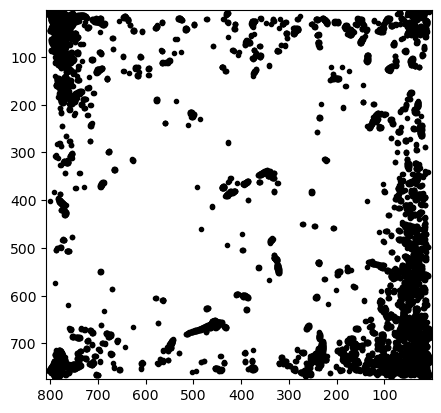

In [6]:
marks3 = RedDFFromIm(im3)
marks5 = RedDFFromIm(im5)
marks6 = RedDFFromIm(im6)
marks7 = RedDFFromIm(im7)
marks91 = RedDFFromIm(im91)
marks92 = RedDFFromIm(im92)

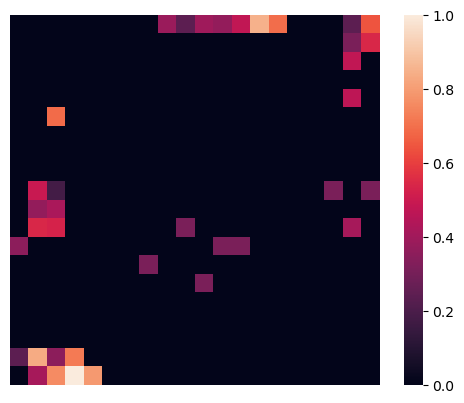

In [8]:
hm3 = make_occup_map(marks3,20)

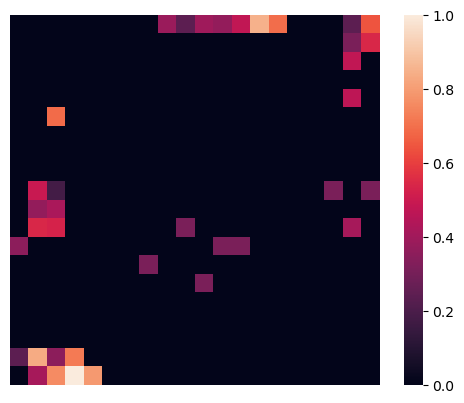

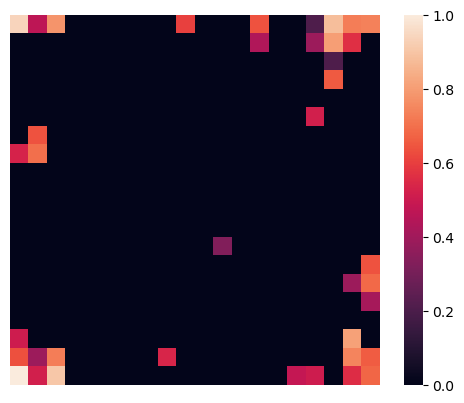

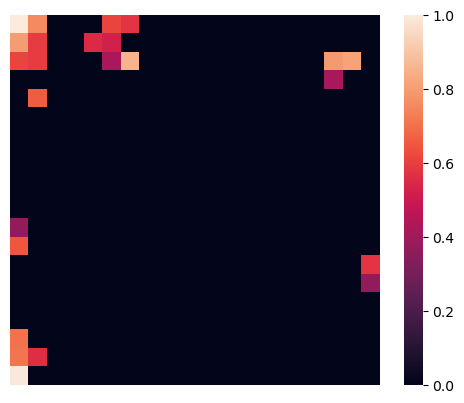

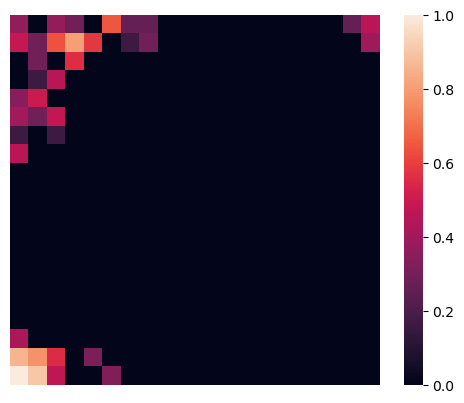

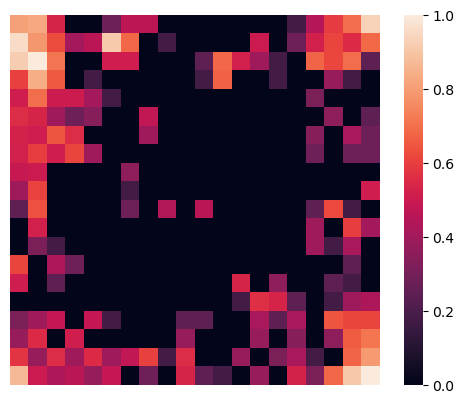

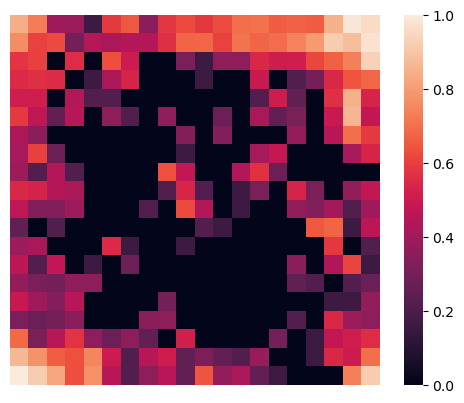

In [13]:
hm3 = make_occup_map(marks3,20)
hm5 = make_occup_map(marks5,20)
hm6 = make_occup_map(marks6,20)
hm7 = make_occup_map(marks7,20)
hm91 = make_occup_map(marks91,20)
hm92 = make_occup_map(marks92,20)

### Occupancy map

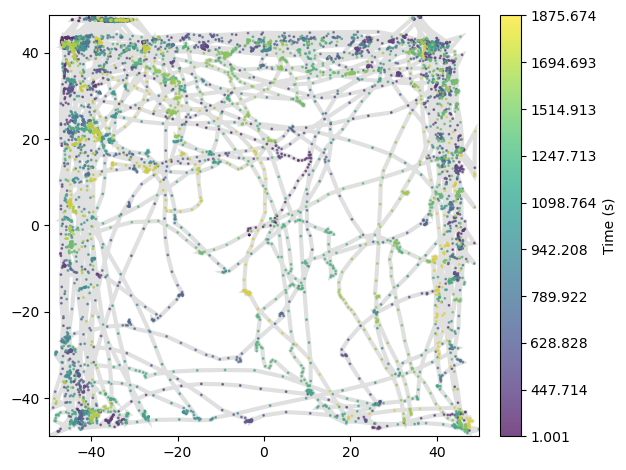

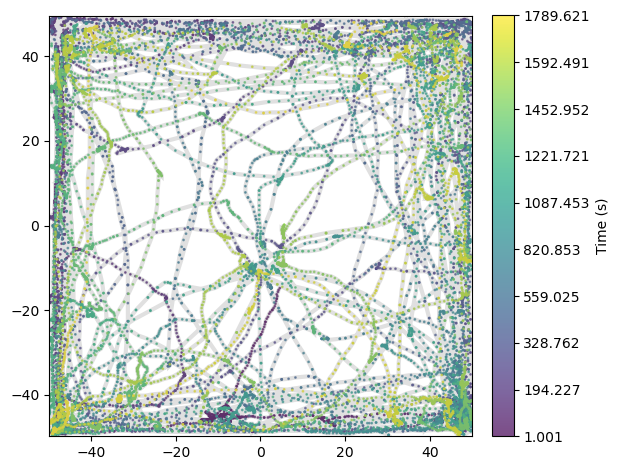

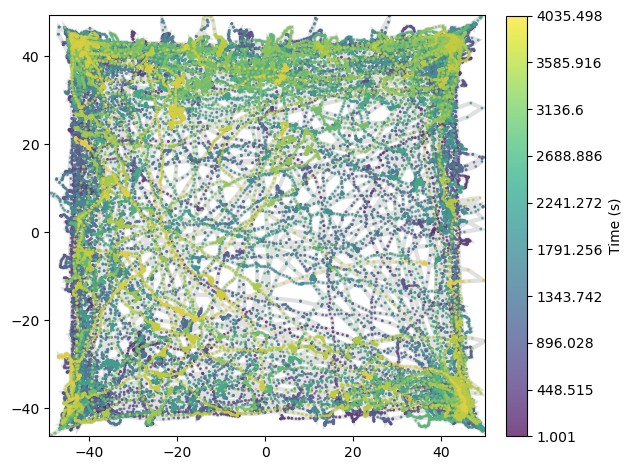

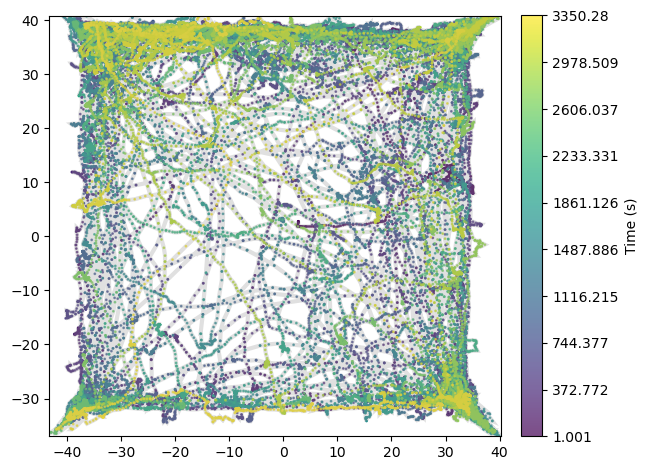

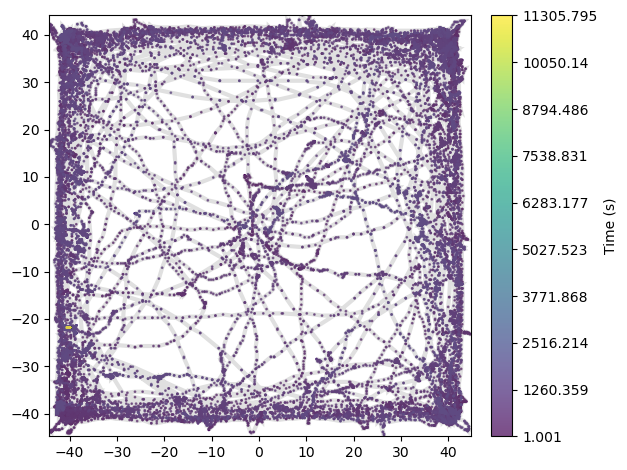

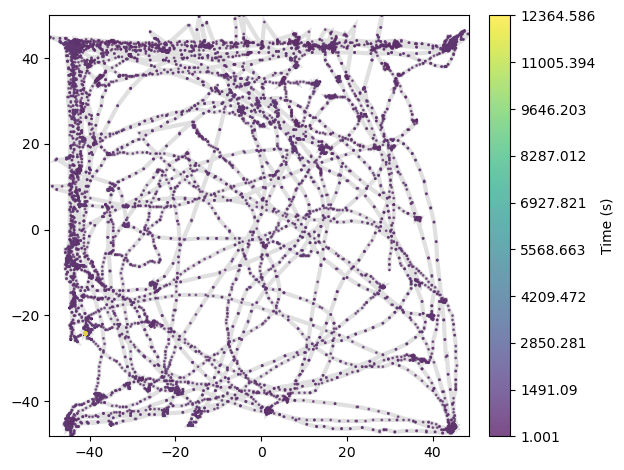

In [14]:
#tr4 = openFile('Trace_4.txt')
tr3 = openFile('Trace_3.txt')
tr5 = openFile('Trace_5.txt')
tr6 = openFile('Trace_6.txt')
tr7 = openFile('Trace_7.txt')
tr91 = openFile('Trace_9.1.txt')
tr92 = openFile('Trace_9.2.txt')

7 и 91 хорошо бы вырезать прыжки

False False
False False
False False
False False
False False
False False


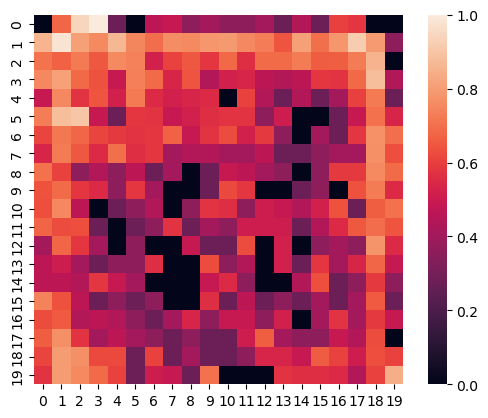

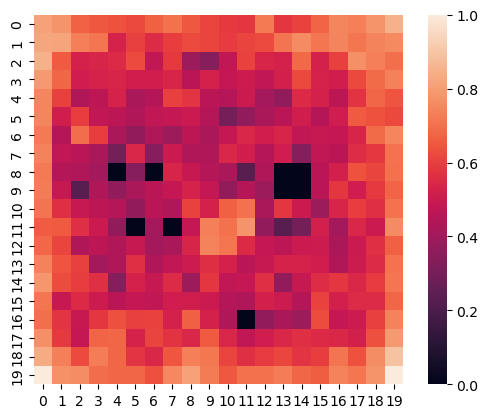

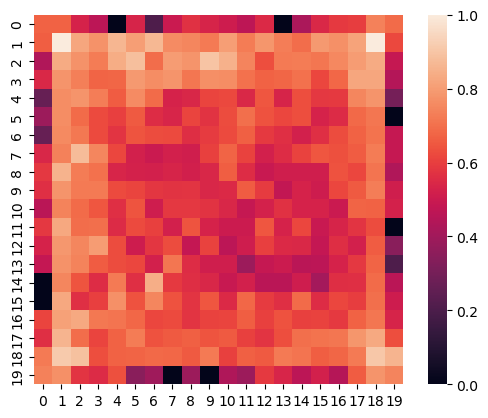

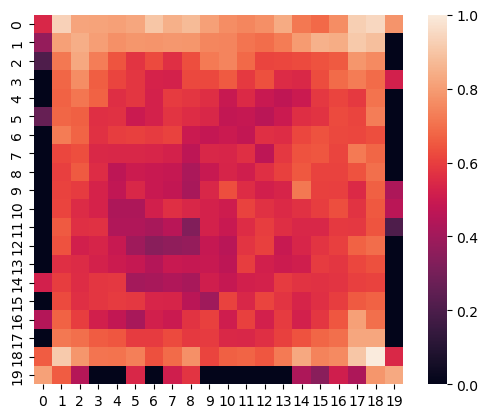

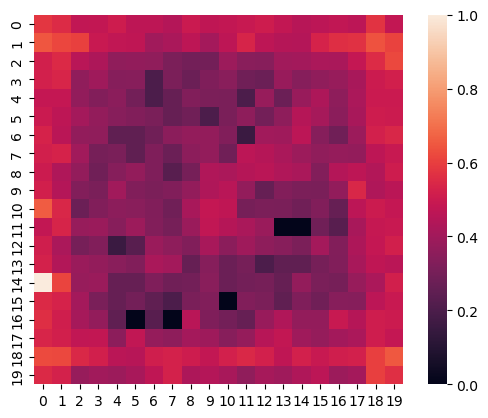

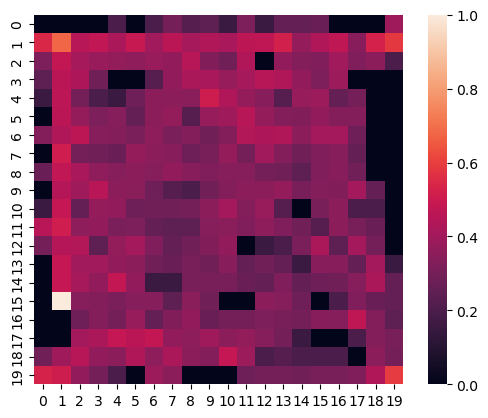

In [16]:
occ3 = occupMapNorm(tr3,20)
occ5 = occupMapNorm(tr5,20)
occ6 = occupMapNorm(tr6,20)
occ7 = occupMapNorm(tr7,20)
occ91 = occupMapNorm(tr91,20)
occ92 = occupMapNorm(tr92,20)

In [69]:
#print(occ3.shape)
#print(hm3.shape)

In [21]:
#corr = signal.correlate2d(occ3, hm3, boundary='symm', mode='full')
#sns.heatmap(corr, square=True)

In [123]:
type(occ3)

numpy.ndarray

<AxesSubplot:>

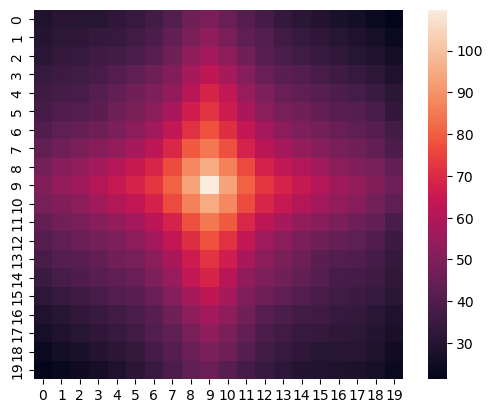

In [31]:
corr = signal.correlate2d(occ3, occ3, mode='same')
sns.heatmap(corr, square=True)

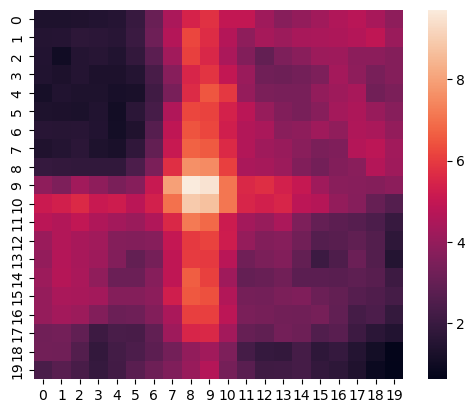

In [32]:
corr = signal.correlate2d(occ3, hm3, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corr3.png")

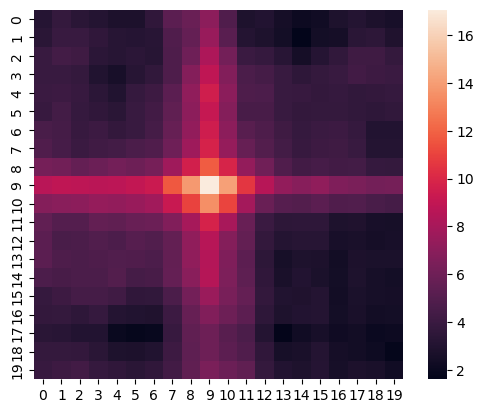

In [33]:
corr = signal.correlate2d(occ5, hm5, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corr5.png")

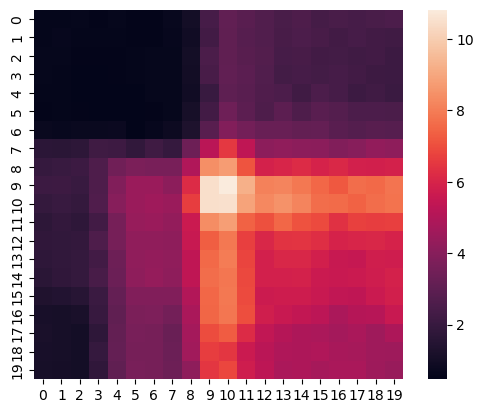

In [34]:
corr = signal.correlate2d(occ6, hm6, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corr6.png")

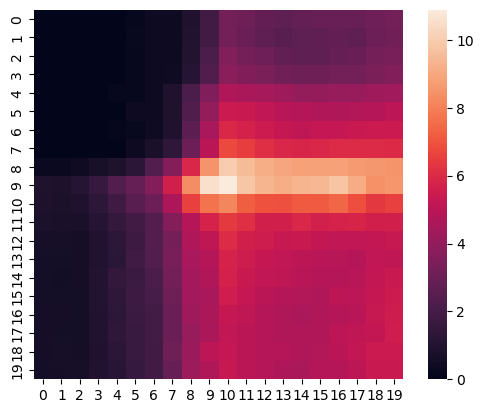

In [35]:
corr = signal.correlate2d(occ7, hm7, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corr7.png")

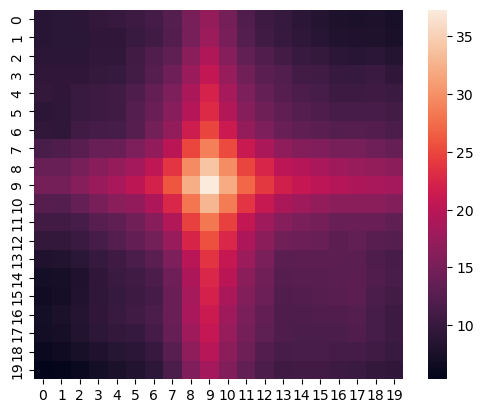

In [37]:
corr = signal.correlate2d(occ91, hm91, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corr91.png")

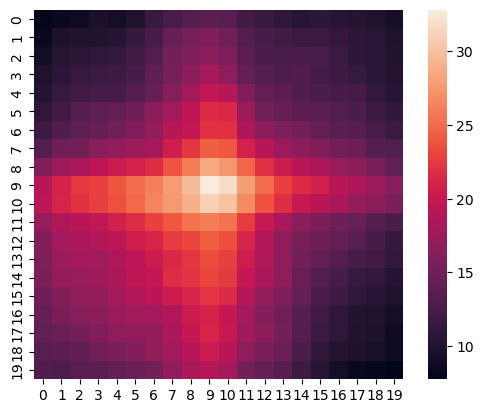

In [38]:
corr = signal.correlate2d(occ92, hm92, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corr92.png")

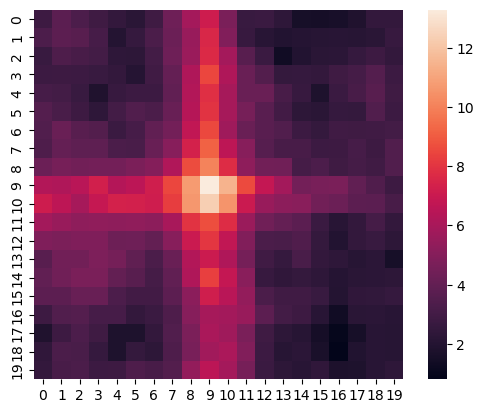

In [39]:
corr = signal.correlate2d(occ3, hm5, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corrNotTrue35.png")

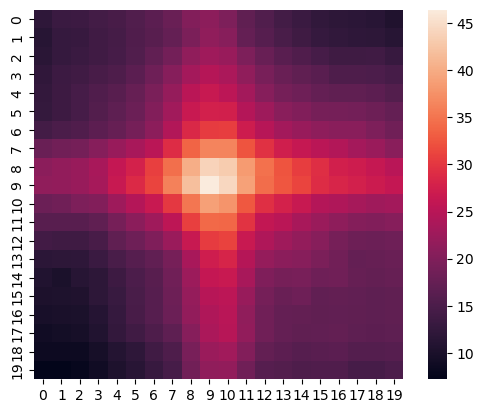

In [40]:
corr = signal.correlate2d(occ7, hm91, mode='same')
sns.heatmap(corr, square=True)
plt.savefig("C:\\Users\\Lenovo\\1navigation\\correlation_maps\\corrNotTrue791.png")